## Prétraitement

In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import load_data_excel, convert_numeric_columns
from src.features import get_simplified_names, onehot_encode_categorical_feature
from src.experiments_bruit_val import (
    prepare_data_random_split, train_xgboost_models
)
from src.visu import plot_ml_results
from sklearn.preprocessing import StandardScaler
from src.bruit_val import add_noise_after_split

# Load data
data = load_data_excel('../data/sources/Donnees_IA_2025.xlsx')

# Define variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut",
    "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut",
    "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut",
    "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

# Convert numeric columns
data = convert_numeric_columns(data, vars_expl + vars_cibles)

# Get simplified names
simplified_names = get_simplified_names()

print(f" Data loaded: {len(data)} observations")

 Data loaded: 6376 observations


### Scenario : All Features + Nom Encoded

In [2]:
l_std = np.arange(0, 1.05, 0.05)
R2=[[] for k in range(0,3)]
l_var= ['train','test','both']
i=0

X_train_cat, X_test_cat, y_train_cat, y_test_cat = prepare_data_random_split(
data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

indices_train_cat = X_train_cat.index
indices_test_cat = X_test_cat.index


# Standardisation
scaler = StandardScaler()
X_train_cat_scaled = scaler.fit_transform(X_train_cat)
X_test_cat_scaled = scaler.transform(X_test_cat)


for var in l_var:
    for k in range(len(l_std)):
        noise=l_std[k]

        # Ajout du bruit
        X_train_cat_noisy, X_test_cat_noisy = add_noise_after_split(
            X_train_cat_scaled,
            X_test_cat_scaled,
            noise_std=noise,
            random_state=42,
            noise_on=var
        )

        # Retour à l’échelle originale
        X_train_cat_final = scaler.inverse_transform(X_train_cat_noisy)
        X_test_cat_final = scaler.inverse_transform(X_test_cat_noisy)

        # Add one-hot encoded Nom feature
        X_train_cat, X_test_cat = onehot_encode_categorical_feature(
            X_train_cat, X_test_cat, data, "Nom", indices_train_cat, indices_test_cat, drop_first=False
        )

        # Entraînement sur données en unités physiques
        results_cat_all, metrics_cat_all, models_cat_all, ypred_cat_all = train_xgboost_models(
            X_train_cat_final, X_test_cat_final, y_train_cat, y_test_cat,
            vars_cibles, simplified_names, random_state=42, ypred=True
        )
        R2[i].append(metrics_cat_all['R2_uniform'])
    i+=1
print(R2)


[[0.9903, 0.9884, 0.9855, 0.9786, 0.9731, 0.9694, 0.9642, 0.9583, 0.9512, 0.9406, 0.933, 0.9253, 0.9151, 0.9019, 0.8918, 0.8839, 0.8718, 0.8644, 0.845, 0.8383, 0.8243], [0.9903, 0.9511, 0.9251, 0.901, 0.8791, 0.8563, 0.8299, 0.8048, 0.7792, 0.7482, 0.7165, 0.6847, 0.6539, 0.6191, 0.587, 0.5523, 0.514, 0.4784, 0.4408, 0.4067, 0.367], [0.9903, 0.9851, 0.977, 0.9639, 0.9497, 0.9381, 0.9202, 0.9024, 0.8818, 0.8651, 0.8474, 0.8305, 0.8091, 0.7866, 0.7664, 0.7449, 0.7242, 0.702, 0.6868, 0.6597, 0.6349]]


In [3]:
print(len(R2))
print(len(R2[0]))
print(len(l_std))

3
21
21


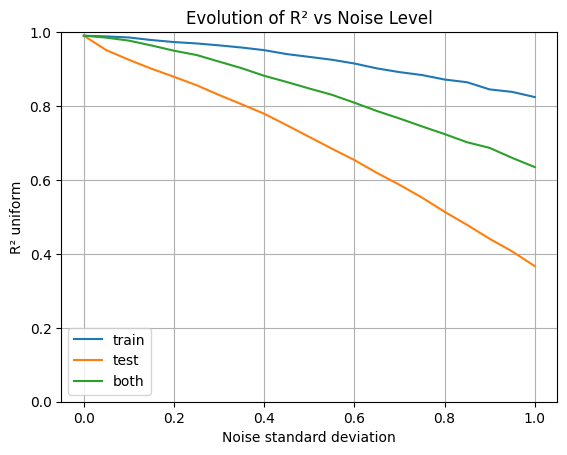

In [4]:
import matplotlib.pyplot as plt

plt.figure()

for i, label in enumerate(l_var):
    plt.plot(l_std, R2[i], label=label)

plt.xlabel("Noise standard deviation")
plt.ylabel("R² uniform")
plt.title("Evolution of R² vs Noise Level")
plt.legend()
plt.ylim((0,1))
plt.grid(True)

plt.show()

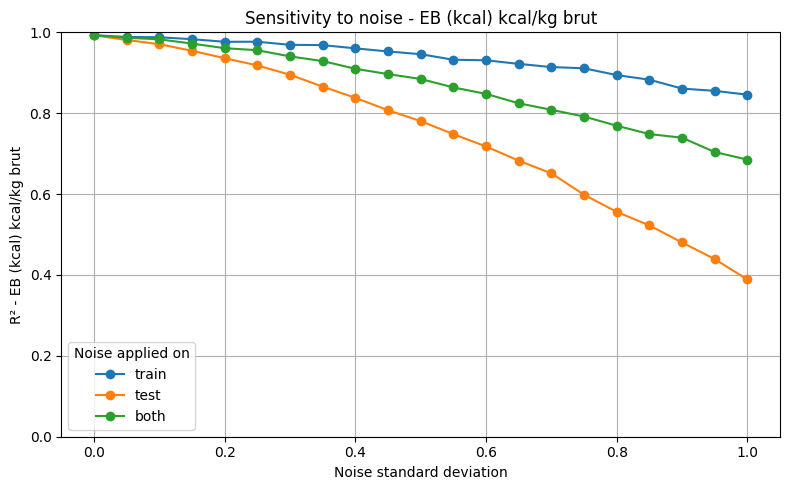

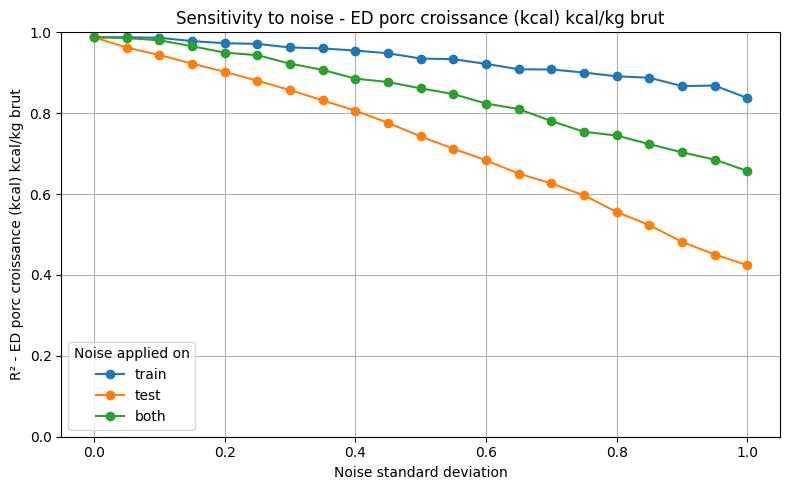

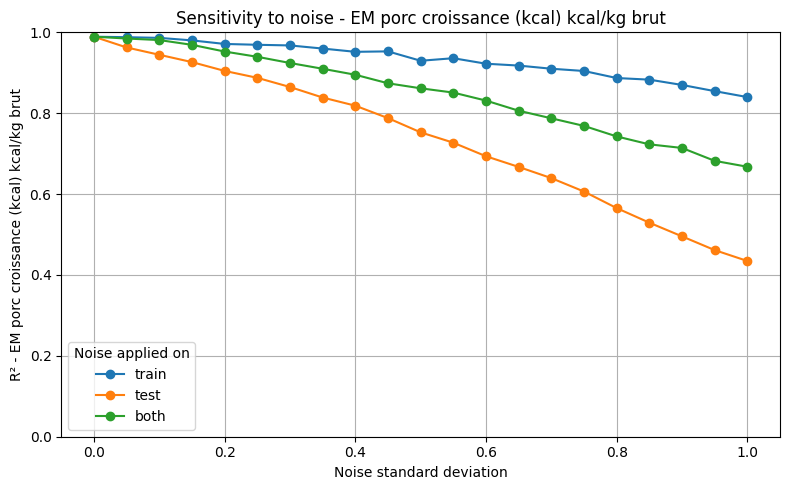

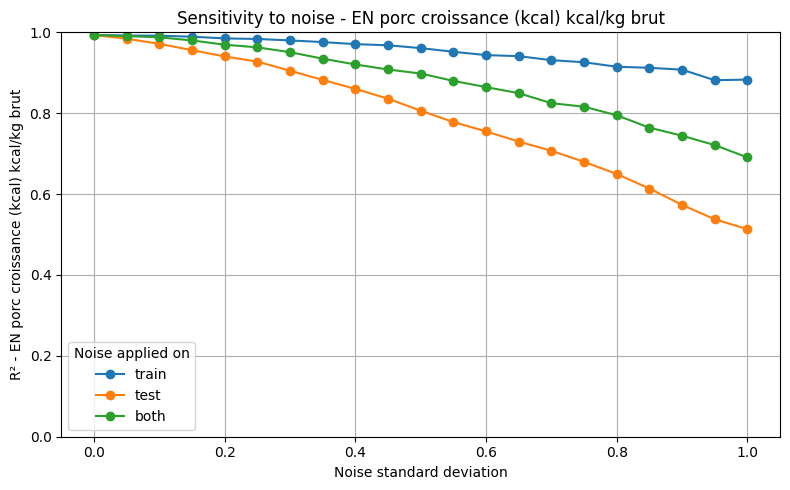

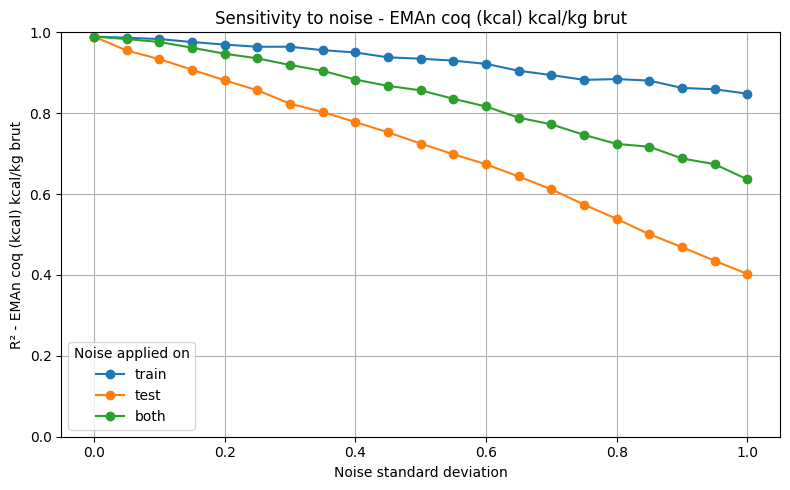

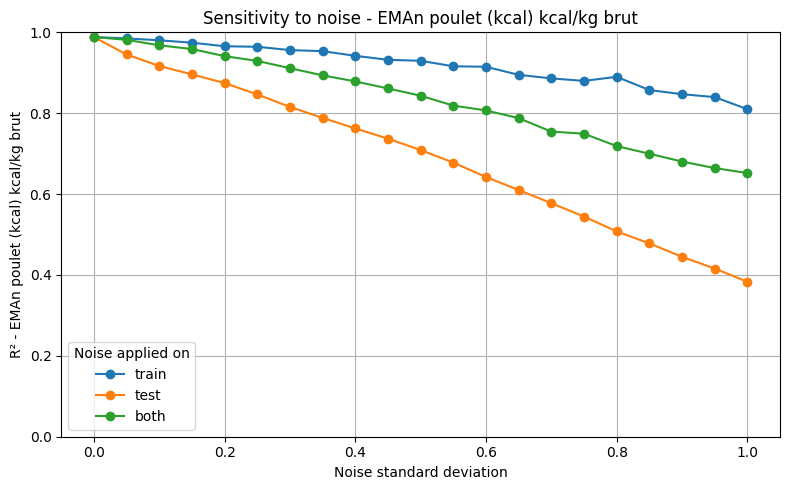

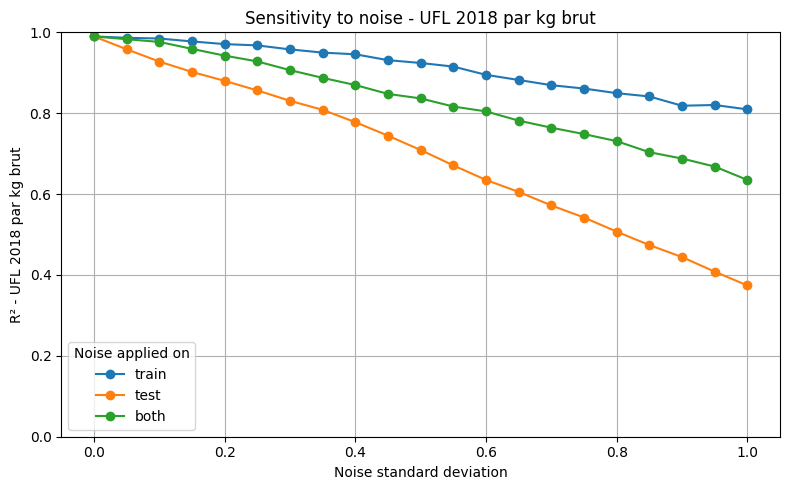

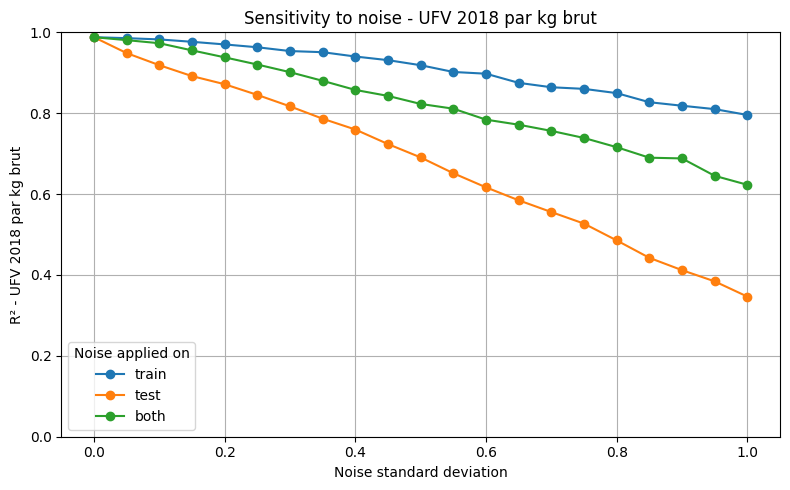

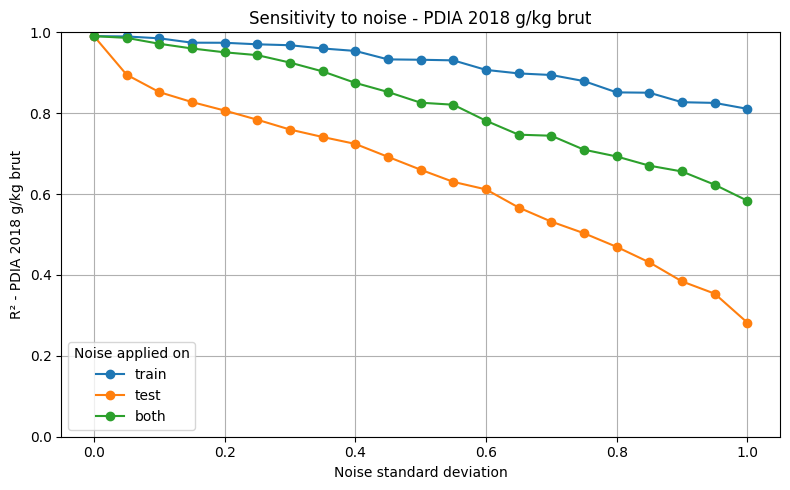

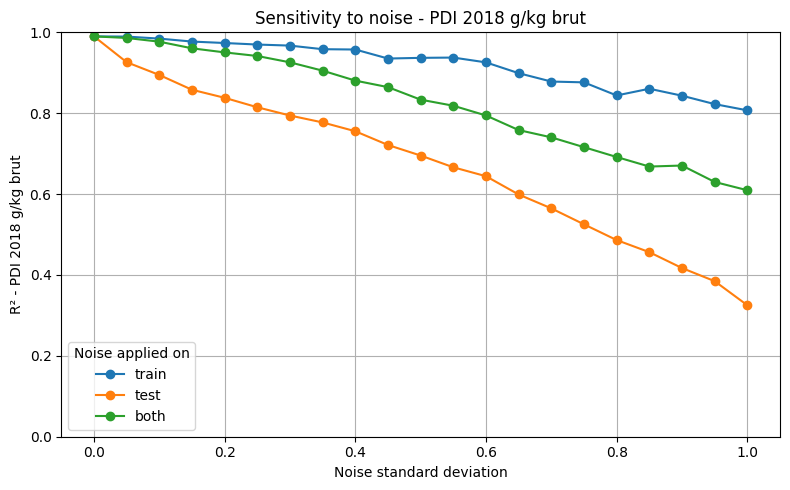

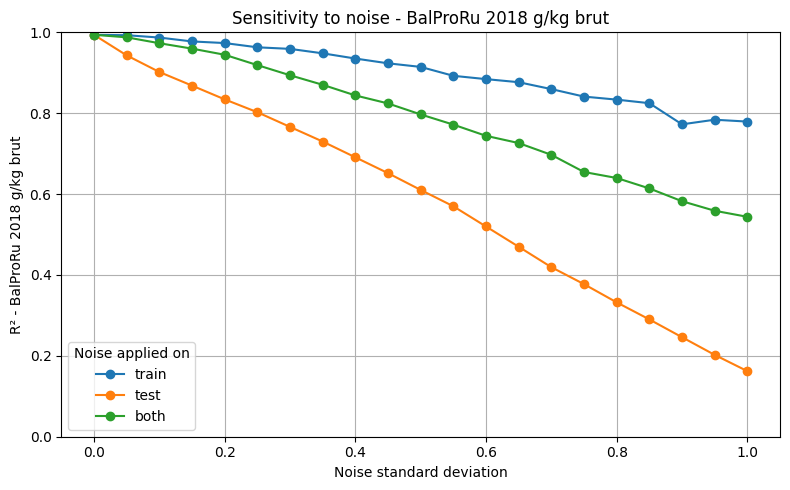

In [5]:

# -----------------------------
# Paramètres
# -----------------------------
l_std = np.arange(0, 1.05, 0.05)
l_var = ['train', 'test', 'both']
n_cases = len(l_var)

# -----------------------------
#Split une seule fois
# -----------------------------
X_train_cat, X_test_cat, y_train_cat, y_test_cat = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

indices_train_cat = X_train_cat.index
indices_test_cat = X_test_cat.index



# -----------------------------
# Standardisation une seule fois
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cat)
X_test_scaled = scaler.transform(X_test_cat)

# -----------------------------
# Initialisation stockage
# -----------------------------
n_outputs = len(vars_cibles)

# Structure : R2[case][output][noise_level]
R2_2 = [[[] for _ in range(n_outputs)] for _ in range(n_cases)]

# -----------------------------
# Boucle sur scénarios + bruit
# -----------------------------
for i, var in enumerate(l_var):

    for noise in l_std:

        # Ajout bruit
        X_train_noisy, X_test_noisy = add_noise_after_split(
            X_train_scaled,
            X_test_scaled,
            noise_std=noise,
            random_state=42,
            noise_on=var
        )

        # Retour échelle originale
        X_train_final = scaler.inverse_transform(X_train_noisy)
        X_test_final = scaler.inverse_transform(X_test_noisy)

        # Add one-hot encoded Nom feature
        X_train_cat, X_test_cat = onehot_encode_categorical_feature(
            X_train_cat, X_test_cat, data, "Nom", indices_train_cat, indices_test_cat, drop_first=False
        )

        # Entraînement
        results_cat_all, metrics_cat_all, models_cat_all, ypred_cat_all = train_xgboost_models(
            X_train_final, X_test_final, y_train_cat, y_test_cat,
            vars_cibles, simplified_names, random_state=42, ypred=True
        )

        # Stockage R2 individuel
        for j in range(n_outputs):
            R2_2[i][j].append(results_cat_all.loc[j, "R2"])

# -----------------------------
# Tracé : un graphe par sortie
# -----------------------------
for j in range(n_outputs):

    plt.figure(figsize=(8,5))

    for i, label in enumerate(l_var):
        plt.plot(l_std, R2_2[i][j], marker='o', label=label)

    plt.xlabel("Noise standard deviation")
    plt.ylabel(f"R² - {vars_cibles[j]}")
    plt.title(f"Sensitivity to noise - {vars_cibles[j]}")
    plt.legend(title="Noise applied on")
    plt.grid(True)
    plt.tight_layout()
    plt.ylim((0,1))
    plt.show()

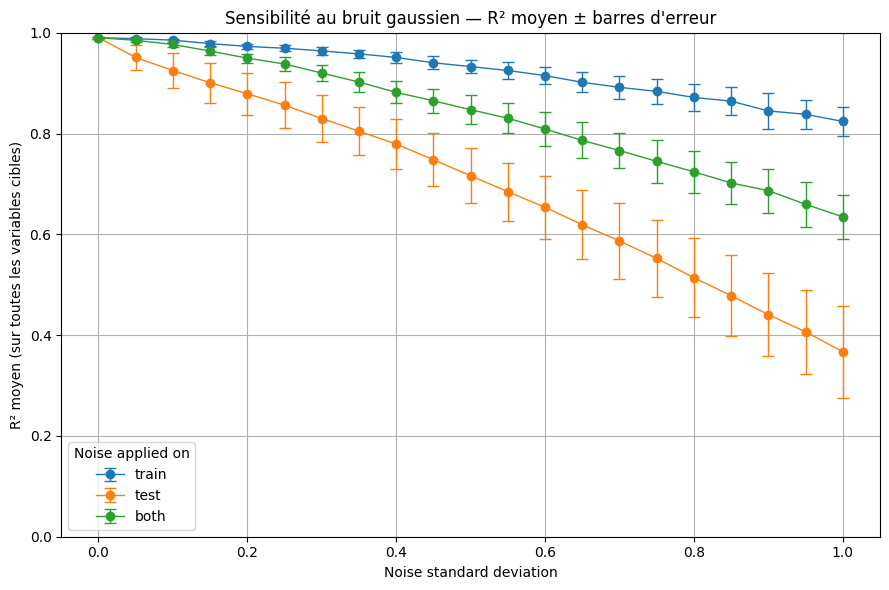

In [6]:
# Convertit R2_2 en array: shape = (n_cases, n_outputs, n_noise_levels)
R2_arr = np.array(R2_2, dtype=float)

# Moyenne et barres d'erreurs sur les sorties (axes outputs)
mean_r2 = R2_arr.mean(axis=1)               # (n_cases, n_noise)
std_r2  = R2_arr.std(axis=1, ddof=1)        # (n_cases, n_noise)

# Option: erreur standard de la moyenne (SEM) au lieu de l'écart-type
sem_r2 = std_r2 / np.sqrt(R2_arr.shape[1])  # (n_cases, n_noise)

# Choisis ici la barre d'erreur que tu veux afficher:
yerr = std_r2      # <-- écart-type
# yerr = sem_r2    # <-- ou SEM

# Plot combiné
plt.figure(figsize=(9, 6))

for i, label in enumerate(l_var):
    plt.errorbar(
        l_std,
        mean_r2[i],
        yerr=yerr[i],
        marker="o",
        capsize=4,
        linewidth=1,
        label=label
    )

plt.xlabel("Noise standard deviation")
plt.ylabel("R² moyen (sur toutes les variables cibles)")
plt.title("Sensibilité au bruit gaussien — R² moyen ± barres d'erreur")
plt.ylim((0, 1))
plt.grid(True)
plt.legend(title="Noise applied on")
plt.tight_layout()
plt.show()